## 实现拓扑排序

In [1]:
simple_graph = {
    'a':[1,2,4],
    'b':[2,3]
}
simple_graph.items()

dict_items([('a', [1, 2, 4]), ('b', [2, 3])])

In [61]:
from functools import reduce
import random
import numpy as np
import pandas as pd

In [3]:
reduce(lambda a,b:a+b,list(simple_graph.values()))

[1, 2, 4, 2, 3]

In [4]:
list_a = [1,2,3]
list_b = [2,3,4]

set(list_a) & set(list_b)

{2, 3}

In [5]:
def topologic(graph):
    """
    graph dict
    {
        node:[node1,node2,..,noden] #链接它的点
        
        x:[linear],
        k:[linear],
        b:[linear],
        linear:[sigmoid],
        sigmoid:[loss],
        y:[loss]
    }
    """
    sorted_node = []
    while graph:
        all_nodes_have_inputs = reduce(lambda a,b:a+b,list(graph.values())) #所有有输入的节点
        all_nodes_have_outputs = list(graph.keys()) # 所有有输出的节点
        all_nodes_only_have_outputs_no_inputs = set(all_nodes_have_outputs) - set(all_nodes_have_inputs) 
        
#          for n in graph: 
#             all_nodes_have_input += graph[n]
#             all_nodes_have_output.append(n)
        
        if all_nodes_only_have_outputs_no_inputs:
            node = random.choice(list(all_nodes_only_have_outputs_no_inputs))
            sorted_node.append(node)
            
            if len(graph)==1:
                sorted_node+=graph[node]
            
            graph.pop(node)
            
            for _,links in graph.items():
                if node in links:
                    links.remove(node)
        else:
            raise TypeError('this graph has circle,which cannot get topological order')
        
    return sorted_node
    

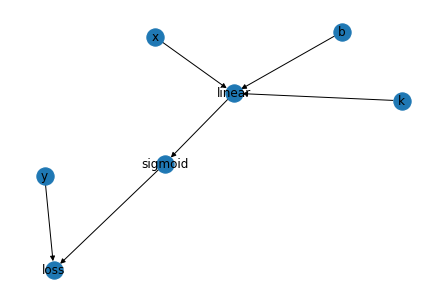

In [6]:
x,linear,k,b,sigmoid,y,loss = 'x','linear','k','b','sigmoid','y','loss'
test_graph = {
        x:[linear],
        k:[linear],
        b:[linear],
        linear:[sigmoid],
        sigmoid:[loss],
        y:[loss]
    }
%matplotlib inline
import networkx as nx
nx.draw(nx.DiGraph(test_graph), with_labels=True)

In [7]:
topologic(test_graph)

['b', 'k', 'x', 'linear', 'y', 'sigmoid', 'loss']

In [8]:
# class Node:
#     def __init__(self, inputs, outputs):
#         self.inputs = inputs
#         self.outputs = outputs
        
# ## Our Simple Model Elements
# node_x = Node(inputs=None, outputs=[node_linear])
# node_y = Node(inputs=None, outputs=[node_loss])
# node_k = Node(inputs=None, outputs=[node_linear])
# node_b = Node(inputs=None, outputs=[node_linear])
# node_linear = Node(inputs=[node_x,node_k,node_b], outputs=[node_sigmoid])
# node_sigmoid = Node(inputs=[node_linear], outputs=[node_loss])
# node_loss = Node(inputs=[node_y,node_sigmoid], outputs=None)

$\partial$

In [9]:
# 神经节点
class Node:
    def __init__(self, inputs=[], name=None, is_trainable=False):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict() # 存储loss对某个值的偏导
        self.is_trainable = is_trainable
        
        for node in inputs:
            node.outputs.append(self)
            
    def forward(self):
        print('I am {},I have no human, I calculate myself value by myself'.format(self.name))
        
    def backward(self):
        for n in self.inputs:
            
            print('I get ∂{}/∂{}'.format(self.name,n.name))
            
    def __repr__(self):
        return 'Node: {}'.format(self.name)
    
    

# 站位节点，没有输入的节点，其值要指定
class Placeholder(Node):
    def __init__(self, name=None, is_trainable=False):
        Node.__init__(self, name=name, is_trainable=is_trainable)
            
    def forward(self, value=None):
        print('I am {},I was assigned value:{} by human!!'.format(self.name,self.value))
        
    def backward(self):
        self.gradients[self] = self.outputs[0].gradients[self]
        print('I got myself gradients:{}'.format(self.outputs[0].gradients[self]))
    
            
    def __repr__(self):
        return 'Placeholder: {}'.format(self.name)
    
# 线性节点
class Linear(Node):
    def __init__(self, x, k, b, name=None):
        Node.__init__(self, inputs=[x, k, b], name=name)
            
    def forward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
        print('I am {},I have no human, I calculate myself value:{} by myself'.format(self.name,self.value))
        
    def backward(self):
#         self.gradients[self.inputs[0]] =  '*'.join([self.outputs[0].gradients[self],'∂{}/∂{}'.format(self.name,self.inputs[0].name)]) # linear的输入对他自己的偏导
#         self.gradients[self.inputs[1]] =  '*'.join([self.outputs[0].gradients[self],'∂{}/∂{}'.format(self.name,self.inputs[1].name)]) # 
#         self.gradients[self.inputs[2]] =  '*'.join([self.outputs[0].gradients[self],'∂{}/∂{}'.format(self.name,self.inputs[2].name)]) # linear的输入对他自己的偏导
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.gradients[self.inputs[0]] =  self.outputs[0].gradients[self] * k.value
        self.gradients[self.inputs[1]] =  self.outputs[0].gradients[self] * x.value
        self.gradients[self.inputs[2]] =  self.outputs[0].gradients[self] * 1
        
        print('self.gradients[self.inputs[0]]: {}'.format(self.gradients[self.inputs[0]]))
        print('self.gradients[self.inputs[1]]: {}'.format(self.gradients[self.inputs[1]]))
        print('self.gradients[self.inputs[2]]: {}'.format(self.gradients[self.inputs[2]]))
            
    def __repr__(self):
        return 'Linear: {}'.format(self.name)
    
# sigmoid 激活节点
class Sigmoid(Node):
    def __init__(self, x, name=None):
        Node.__init__(self, inputs=[x], name=name)
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))
            
    def forward(self):
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
        print('I am {},I have no human, I calculate myself value{} by myself'.format(self.name,self.value))
        
    def backward(self):
        x = self.inputs[0]
#         self.gradients[self.inputs[0]] =  '*'.join([self.outputs[0].gradients[self],'∂{}/∂{}'.format(self.name,self.inputs[0].name)]) # sigmoid的output是loss 对他自己的偏导
        self.gradients[self.inputs[0]] =  self.outputs[0].gradients[self] * (self._sigmoid(x.value) * (1- self._sigmoid(x.value)))
        print('self.gradients[self.inputs[0]]: {}'.format(self.gradients[self.inputs[0]]))
            
    def __repr__(self):
        return 'Sigmoid: {}'.format(self.name)

# 损失函数
class Loss(Node):
    def __init__(self, y, y_hat,name=None):
        Node.__init__(self, inputs=[y, y_hat], name=name)
    
            
    def forward(self):
        y = self.inputs[0]
        y_hat = self.inputs[1]
        self.value = np.mean((y.value - y_hat.value)**2)
        print('I am {},I have no human, I calculate myself value{} by myself'.format(self.name,self.value))
        
    def backward(self):
        y = self.inputs[0]
        y_hat = self.inputs[1]
#         self.gradients[self.inputs[0]] = '∂{}/∂{}'.format(self.name,self.inputs[0].name) # y
#         self.gradients[self.inputs[1]] = '∂{}/∂{}'.format(self.name,self.inputs[1].name) # y_hat
        self.gradients[self.inputs[0]] = 2 * np.mean(y.value - y_hat.value)
        self.gradients[self.inputs[1]] = -2 * np.mean(y.value - y_hat.value)
        print('self.gradients[self.inputs[0]]: {} | {}'.format(self.inputs[0].name, self.gradients[self.inputs[0]]))
        print('self.gradients[self.inputs[1]]: {} | {}'.format(self.inputs[1].name, self.gradients[self.inputs[1]]))
        
    def __repr__(self):
        return 'Loss: {}'.format(self.name)   

        
## Our Simple Model Elements
node_x = Placeholder(name='x') # 需要被赋值的量
node_y = Placeholder(name='y')
node_k = Placeholder(name='k', is_trainable=True)
node_b = Placeholder(name='b', is_trainable=True)
node_linear = Linear(x=node_x, k=node_k, b=node_b,name='linear')
node_sigmoid = Sigmoid(x=node_linear,name='sigmoid')
node_loss = Loss(y=node_y, y_hat=node_sigmoid,name='loss')

In [10]:
# need_expand = [node_x, node_y, node_b, node_k]  # 在Google管x,y,k,b这种东西叫 placeholder  feeddictionary
 
# from collections import defaultdict

# computing_graph = defaultdict(list)
# while need_expand:
#     n = need_expand.pop(0)
    
#     if n in computing_graph:
#         continue
        
#     for m in n.outputs:
#         computing_graph[n].append(m)
#         need_expand.append(m)

In [11]:
from collections import defaultdict
feed_dict = {
    node_x:3,
    node_y:random.random(),
    node_k:random.random(),
    node_b:0.38
}

def convert_feed_dict_to_graph(feed_dict):
    need_expend = [n for n in feed_dict]
    
    comput_graph = defaultdict(list)
    
    while need_expend:
        n = need_expend.pop(0)
        
        if n in comput_graph:
            continue
            
        if isinstance(n,Placeholder):
            n.value = feed_dict[n]
            
        for m in n.outputs:
            comput_graph[n].append(m)
            need_expend.append(m)
    return comput_graph

In [12]:
sorted_nodes = topologic(convert_feed_dict_to_graph(feed_dict))
sorted_nodes

[Placeholder: b,
 Placeholder: y,
 Placeholder: k,
 Placeholder: x,
 Linear: linear,
 Sigmoid: sigmoid,
 Loss: loss]

## 模拟神经网络计算过程

In [13]:
for node in sorted_nodes:
    node.forward()

I am b,I was assigned value:0.38 by human!!
I am y,I was assigned value:0.07043172837807543 by human!!
I am k,I was assigned value:0.4474092987563224 by human!!
I am x,I was assigned value:3 by human!!
I am linear,I have no human, I calculate myself value:1.7222278962689672 by myself
I am sigmoid,I have no human, I calculate myself value0.8484155809319192 by myself
I am loss,I have no human, I calculate myself value0.6052588748345209 by myself


In [14]:
for node in sorted_nodes[::-1]:
    print('\nI am {}'.format(node.name))
    node.backward()


I am loss
self.gradients[self.inputs[0]]: y | -1.5559677051076874
self.gradients[self.inputs[1]]: sigmoid | 1.5559677051076874

I am sigmoid
self.gradients[self.inputs[0]]: 0.20010768975603932

I am linear
self.gradients[self.inputs[0]]: 0.08953004114949727
self.gradients[self.inputs[1]]: 0.600323069268118
self.gradients[self.inputs[2]]: 0.20010768975603932

I am x
I got myself gradients:0.08953004114949727

I am k
I got myself gradients:0.600323069268118

I am y
I got myself gradients:-1.5559677051076874

I am b
I got myself gradients:0.20010768975603932


In [15]:
# optimize
learning_rate = 1e-1
for node in sorted_nodes:
    if node.is_trainable:
        node.value = node.value -1 * node.gradients[node] * learning_rate
        cmp = 'large' if node.gradients[node]>0 else 'small'
        print('{} value is to {},I need update myself'.format(node.name,cmp))

b value is to large,I need update myself
k value is to large,I need update myself


In [28]:
def forward(graph_sorted_nodes):
    for node in graph_sorted_nodes:
        node.forward()
        if isinstance(node,Loss):
            print('loss value:{}'.format(node.value))

In [29]:
def backward(graph_sorted_nodes):
    for node in graph_sorted_nodes[::-1]:
        print('\nI am: {}'.format(node.name))
        node.backward()

In [43]:
def optimize(graph_nodes,learning_rate=1e-3):
    learning_rate=learning_rate
    for node in sorted_nodes:
        if node.is_trainable:
            node.value = node.value -1 *node.gradients[node]*learning_rate
            cmp = 'large' if node.gradients[node] >0 else 'small'
            print('{} value is to {},I need update myself to {}'.format(node.name,cmp,node.value))

In [44]:
# 前一次后一次叫一次epoch
def run_one_epoch(graph_sorted_nodes):
    forward(graph_sorted_nodes)
    backward(graph_sorted_nodes)

In [45]:
# 完整的一次求值=求导-更新 应该是：
run_one_epoch(sorted_nodes)
optimize(sorted_nodes)

I am b,I was assigned value:0.32606436283993107 by human!!
I am y,I was assigned value:0.07043172837807543 by human!!
I am k,I was assigned value:0.2856023872761159 by human!!
I am x,I was assigned value:3 by human!!
I am linear,I have no human, I calculate myself value:1.1828715246682788 by myself
I am sigmoid,I have no human, I calculate myself value0.7654637186763411 by myself
I am loss,I have no human, I calculate myself value0.4830694675379685 by myself
loss value:0.4830694675379685

I am: loss
self.gradients[self.inputs[0]]: y | -1.3900639805965314
self.gradients[self.inputs[1]]: sigmoid | 1.3900639805965314

I am: sigmoid
self.gradients[self.inputs[0]]: 0.24955681592588919

I am: linear
self.gradients[self.inputs[0]]: 0.07127402238946018
self.gradients[self.inputs[1]]: 0.7486704477776676
self.gradients[self.inputs[2]]: 0.24955681592588919

I am: x
I got myself gradients:0.07127402238946018

I am: k
I got myself gradients:0.7486704477776676

I am: y
I got myself gradients:-1.3900

In [46]:
loss_history = []
for _ in range(100):
    run_one_epoch(sorted_nodes)
    __loss_node = sorted_nodes[-1]
    assert isinstance(__loss_node, Loss)
    loss_history.append(__loss_node.value)
    optimize(sorted_nodes,learning_rate=1e-1)

I am b,I was assigned value:0.3258148060240052 by human!!
I am y,I was assigned value:0.07043172837807543 by human!!
I am k,I was assigned value:0.28485371682833827 by human!!
I am x,I was assigned value:3 by human!!
I am linear,I have no human, I calculate myself value:1.18037595650902 by myself
I am sigmoid,I have no human, I calculate myself value0.7650153950111297 by myself
I am loss,I have no human, I calculate myself value0.48244646995341783 by myself
loss value:0.48244646995341783

I am: loss
self.gradients[self.inputs[0]]: y | -1.3891673332661085
self.gradients[self.inputs[1]]: sigmoid | 1.3891673332661085

I am: sigmoid
self.gradients[self.inputs[0]]: 0.24972622229799815

I am: linear
self.gradients[self.inputs[0]]: 0.07113544261108462
self.gradients[self.inputs[1]]: 0.7491786668939945
self.gradients[self.inputs[2]]: 0.24972622229799815

I am: x
I got myself gradients:0.07113544261108462

I am: k
I got myself gradients:0.7491786668939945

I am: y
I got myself gradients:-1.3891

In [47]:
loss_history

[0.48244646995341783,
 0.41831836049082943,
 0.3489129185954978,
 0.2799722162129988,
 0.21798067928831752,
 0.16722359409569926,
 0.12843334815512575,
 0.09986555734254793,
 0.07904061282009468,
 0.0637581511667006,
 0.052371134045768514,
 0.043728617359789834,
 0.037044199365082416,
 0.03178060392757439,
 0.027566846288487656,
 0.024142799145997037,
 0.021322923848672407,
 0.018972579108592992,
 0.01699241602750683,
 0.015307964472887348,
 0.0138625781759934,
 0.012612579566074771,
 0.011523865952848556,
 0.010569501172539698,
 0.009727981820780128,
 0.00898197206486715,
 0.008317368540231187,
 0.007722600897311652,
 0.00718810272241441,
 0.006705907116447655,
 0.006269334513015525,
 0.005872749473689808,
 0.0055113695806703385,
 0.0051811140480297994,
 0.00487848288230083,
 0.004600459736053009,
 0.00434443328156206,
 0.004108133168653499,
 0.0038895775479261155,
 0.003687029826361363,
 0.0034989628393197617,
 0.003324029015676923,
 0.003161035413409485,
 0.0030089227345542224,
 0.0

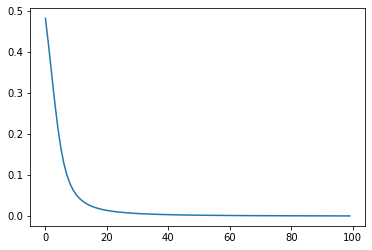

In [48]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [53]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
sigmoid(sorted_nodes[2].value * sorted_nodes[3].value + sorted_nodes[0].value)

0.09065139587219168

In [56]:
sorted_nodes[1].value

0.07043172837807543

In [55]:
sorted_nodes

[Placeholder: b,
 Placeholder: y,
 Placeholder: k,
 Placeholder: x,
 Linear: linear,
 Sigmoid: sigmoid,
 Loss: loss]

# 多维版本 想知道底盒出来什么函数，
## 把维度降低到3维空间

In [83]:
import numpy as np
import random

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Placeholder(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

from collections import defaultdict


def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)


def optimize(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [84]:
load_boston()['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [85]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
from tqdm import tqdm_notebook
#from miniflow import *

# Load data
data = load_boston()
# X_ = data['data']
dataframe = pd.DataFrame(data['data'])
dataframe.columns = data['feature_names']
X_ = dataframe[['RM','LSTAT']]
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 200
# Total number of examples
m = X_.shape[0]
batch_size = 1
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [87]:
losses = []

for i in tqdm_notebook(range(epochs)):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1, Loss: 36.127
Epoch: 101, Loss: 17.602



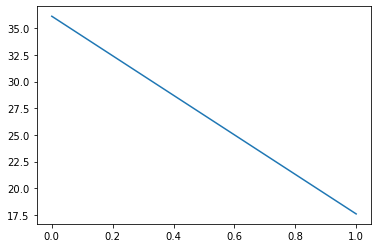

In [88]:
plt.plot(losses)

In [89]:
graph

In [90]:
from mpl_toolkits.mplot3d import Axes3D

predicate_results = []
for rm, ls in X_.values:
    X.value = np.array([[rm,ls]])
    forward_and_backward(graph)
    predicate_results.append(graph[-2].value[0][0])

In [91]:
predicate_results

[26.394579912846048,
 22.427882432226095,
 34.39870803062537,
 34.06259781551033,
 33.37550841664181,
 23.83786473299381,
 19.51068337226319,
 15.242595225071355,
 11.370289733799684,
 15.909544600920363,
 15.087732902431334,
 19.16117063192266,
 17.400401273278323,
 22.115031416283266,
 21.345906348623767,
 21.794324806078382,
 22.481855289871923,
 18.245343662352035,
 19.462268276304563,
 19.627920537949674,
 11.981393425020224,
 18.91340546211066,
 15.31137340046861,
 13.261976803765865,
 16.683438535754092,
 16.491747833049264,
 18.461431403863727,
 15.778611546843372,
 20.00213546805073,
 21.954704307604175,
 11.907003857597712,
 19.249531891846804,
 10.694728964422847,
 14.116909229627474,
 14.591660048441716,
 21.21267421013031,
 19.70959402991408,
 21.642209367712802,
 20.93897823482819,
 27.83193766293781,
 35.68738244447533,
 30.304414570338604,
 22.580187095851638,
 22.38180424653968,
 21.77560855803668,
 19.9183822431283,
 18.93631090604955,
 15.12891369874433,
 11.72766154

In [100]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X_ = dataframe[['RM','LSTAT']].values[:,0]
Y_ = dataframe[['RM','LSTAT']].values[:,1]

Z = predicate_results

rm_and_lstp_price = ax.plot_trisurf(X_,Y_,Z,color='green')

ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Predicted-Price')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Predicted-Price')

<IPython.core.display.Javascript object>

## 如何发布代码到互联网

In [101]:
import sys
print(sys.version)
print(sys.executable)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
/opt/anaconda3/bin/python
